In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from getpass import getpass
from sentence_transformers import SentenceTransformer
from langdetect import detect, LangDetectException

In [2]:
test_sentences = pd.DataFrame( 
    [["I like to play Minecraft.", "en"],
      ["J'aime jouer à Minecraft.", "fr"],
      ["Jag gillar att spela Minecraft.", "se"],
      ["Neo4j is a graph database.", "en"],
      ["Neo4j est une base de données graphique.", "fr"],
      ["Neo4j är en grafdatabase.", "se"]], columns=["sentence", "language"])


In [3]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
test_embeddings = model.encode((test_sentences['sentence'].to_list()))

In [5]:
reducer = umap.UMAP(n_components=2)
embedding_reduced = reducer.fit_transform(test_embeddings)

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [6]:
test_umap_df = pd.DataFrame(embedding_reduced, columns=['umap1', 'umap2'])
test_sentences = pd.concat([test_sentences, test_umap_df], axis=1)

In [7]:
fig = px.scatter(test_sentences, x='umap1', y='umap2', color='language', text=test_sentences['sentence'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.update_traces(
        marker=dict(size=20),  # Increase point size
        textposition='top center'  # Position of the text labels
    )   
fig.show()

In [8]:
bolt_url = "bolt://54.196.239.38:7687"

In [9]:
gds = GraphDataScience(bolt_url, auth=("neo4j", getpass("Neo4j password")))

In [10]:
descriptions_df = gds.run_cypher("MATCH (s:Stream) WHERE s.description IS NOT NULL and size(s.description) > 1 RETURN id(s) AS nodeId, s.description AS description")

In [11]:
descriptions_df.head(25)

,nodeId,description
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin..."
1,3,I'm a variety streamer(kind of). Been streamin...
2,5,感謝します。
3,8,Топовая студия в мире профессионального киберс...
4,11,Maximilian's Livestream Of Hype! Modern fighti...
5,14,楽しんでゲームしていきます
6,15,spawns at midnight (pst)
7,16,On se tape des immenses barres.
8,19,Welcome to my stream! My name is Amouranth and...
9,21,Yes | Epic Gamer | Content Creator for Luminos...


In [12]:
description_embeddings = model.encode(descriptions_df['description'].to_list())

In [13]:
descriptions_df['description_embedding'] = description_embeddings.tolist()

In [14]:
def detect_language(text):
    try:
        language = detect(text)
        return language
    except LangDetectException:
        return "Uknown"

In [15]:
descriptions_df['language'] = descriptions_df['description'].map(detect_language)

In [16]:
descriptions_df.head()

,nodeId,description,description_embedding,language
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.0411677248775959, 0.015329533256590366, -0....",en
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.031273022294044495, 0.021538781002163887, -...",en
2,5,感謝します。,"[0.047866880893707275, -0.02418091706931591, -...",ja
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097575977444649, 0.00705910287797451, -...",ru
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260038167238235, 0.008335496298968792, -...",en


In [17]:
descriptions_df['language'].value_counts()

language
en        1721
es         296
ko         239
de         232
fr         209
pt         189
ru         169
it         147
tr         104
pl          63
ja          44
Uknown      38
nl          34
so          28
fi          27
tl          26
hu          26
id          25
ca          24
da          22
no          22
th          22
sw          16
et          16
cy          16
cs          14
ar          14
af          12
sk          11
zh-tw       11
ro          11
bg          11
sv          10
vi           9
uk           8
hr           8
sl           7
zh-cn        5
mk           4
lt           3
lv           3
sq           2
el           1
fa           1
Name: count, dtype: int64

In [18]:
gds.run_cypher("""
UNWIND $data AS row
MATCH (n) WHERE id(n) = row['nodeId']
SET n.language = row['language']
WITH n, row
CALL db.create.setNodeVectorProperty(n, "descriptionEmbedding", row['description_embedding'])
               """, {"data": descriptions_df.to_dict('records')})

""


In [19]:
gds.graph.drop("descriptions")

g_descriptions, result = gds.graph.cypher.project("""
    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERACTORS]->(s2:Stream)
    WHERE s1.descriptionEmbedding IS NOT NULL AND s2.descriptionEmbedding IS NOT NULL
    RETURN gds.graph.project(
        "descriptions",
        s1,
        s2,
        {
            sourceNodeProperties: s1{.descriptionEmbedding},
            targetNodeProperties: s2{.descriptionEmbedding},
            relationshipProperties: r{.similarity},
            relationshipType: "HAS_SIMILAR_CONTACTS"
        },
        {
            undirectedRelationshipTypes: ["HAS_SIMILAR_CONTACTS"]
        })"""
)
result

relationshipCount                                                25104
graphName                                                 descriptions
query                \n    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERAC...
projectMillis                                                      540
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                         3777
dtype: object

In [20]:
fastRP_df = gds.fastRP.stream(g_descriptions, 
                               propertyRatio = 1.0,
                               featureProperties = ["descriptionEmbedding"],
                               nodeSelfInfluence = 0.25,
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity")

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

In [21]:
gds.fastRP.write(g_descriptions, 
                 propertyRatio = 1.0,
                 featureProperties = ["descriptionEmbedding"],
                 embeddingDimension = 256,
                 iterationWeights = [0.0, 1.0, 1.0],
                 randomSeed = 24,                               
                 relationshipWeightProperty = "similarity",
                 writeProperty = "fastRPPropertyEmbedding")

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          637
writeMillis                                                           1579
configuration            {'writeProperty': 'fastRPPropertyEmbedding', '...
Name: 0, dtype: object

In [22]:
fastRP_df.rename({"embedding":"fastRP_property_embedding"}, inplace=True, axis=1)

In [23]:
descriptions_df = descriptions_df.merge(fastRP_df, on="nodeId")

In [24]:
fastRP_df_no_props = gds.fastRP.stream(g_descriptions, 
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 0,0, 0,0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity")

In [25]:
gds.fastRP.write(g_descriptions, 
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 0,0, 0,0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity",
                               writeProperty="fastRPNoPropertyEmbedding")

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          710
writeMillis                                                             65
configuration            {'writeProperty': 'fastRPNoPropertyEmbedding',...
Name: 0, dtype: object

In [26]:
fastRP_df_no_props.rename({"embedding":"fastRP_no_property_embedding"}, inplace=True, axis=1)

In [27]:
descriptions_df = descriptions_df.merge(fastRP_df_no_props, on="nodeId")

In [28]:
wcc_df = gds.wcc.stream(g_descriptions)
descriptions_df = descriptions_df.merge(wcc_df, on="nodeId")

In [29]:
description_embedding_reduced = reducer.fit_transform(np.array(list(descriptions_df['description_embedding'])))
description_umap_df = pd.DataFrame(description_embedding_reduced, columns=['description_umap1', 'description_umap2'])
descriptions_df = pd.concat([descriptions_df, description_umap_df], axis=1)

In [30]:
fastrp_property_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_property_embedding'])))
fastRP_prop_umap_df = pd.DataFrame(fastrp_property_reduced, columns=['fastRP_property_umap1', 'fastRP_property_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_prop_umap_df], axis=1)

In [31]:
fastrp_no_prop_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_no_property_embedding'])))
fastRP_no_prop_umap_df = pd.DataFrame(fastrp_no_prop_reduced, columns=['fastRP_no_property_umap1', 'fastRP_no_property_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_no_prop_umap_df], axis=1)

In [32]:
descriptions_df.head()

,nodeId,description,description_embedding,language,fastRP_property_embedding,fastRP_no_property_embedding,componentId,description_umap1,description_umap2,fastRP_property_umap1,fastRP_property_umap2,fastRP_no_property_umap1,fastRP_no_property_umap2
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.0411677248775959, 0.015329533256590366, -0....",en,"[0.051113102585077286, 0.05236228555440903, -0...","[-0.18888503313064575, -0.2742992043495178, 0....",0,6.971322,5.915552,18.664879,16.363842,2.235398,-14.651058
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.031273022294044495, 0.021538781002163887, -...",en,"[0.140514075756073, 0.07159759849309921, 0.082...","[0.033907003700733185, -0.15779262781143188, 0...",0,5.854459,5.578441,7.427647,12.026214,6.436522,13.755587
2,5,感謝します。,"[0.047866880893707275, -0.02418091706931591, -...",ja,"[0.06569905579090118, 0.1434735208749771, 0.09...","[0.03214176744222641, -0.03581657260656357, -0...",0,8.498451,0.529152,5.192806,13.200648,11.713996,4.218990
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097575977444649, 0.00705910287797451, -...",ru,"[0.23918992280960083, 0.15352551639080048, 0.1...","[0.09778932482004166, -0.04284091666340828, 0....",0,5.552489,3.789289,9.734987,5.649045,-5.672851,14.409871
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260038167238235, 0.008335496298968792, -...",en,"[0.26717692613601685, 0.07116031646728516, 0.0...","[-0.018954124301671982, -0.0725683867931366, -...",0,6.487375,4.202991,10.573649,13.868817,6.414943,13.719790


In [33]:
fig = px.scatter(descriptions_df, x='description_umap1', y='description_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [34]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_property_umap1', y='fastRP_property_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [35]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_no_property_umap1', y='fastRP_no_property_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [36]:
prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
ORDER BY rand()
LIMIT 1000
CALL db.index.vector.queryNodes("fastRPPropertyEmbedding", 6, s.fastRPPropertyEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
COUNT { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,3}(node)} AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim""")

In [37]:
no_prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
ORDER BY rand()
LIMIT 1000
CALL db.index.vector.queryNodes("fastRPNoPropertyEmbedding", 6, s.fastRPNoPropertyEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
COUNT { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,3}(node)} AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim""")

In [38]:
description_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
ORDER BY rand()
LIMIT 1000
CALL db.index.vector.queryNodes("descriptionEmbedding", 6, s.descriptionEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
COUNT { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,3}(node)} AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim""")

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



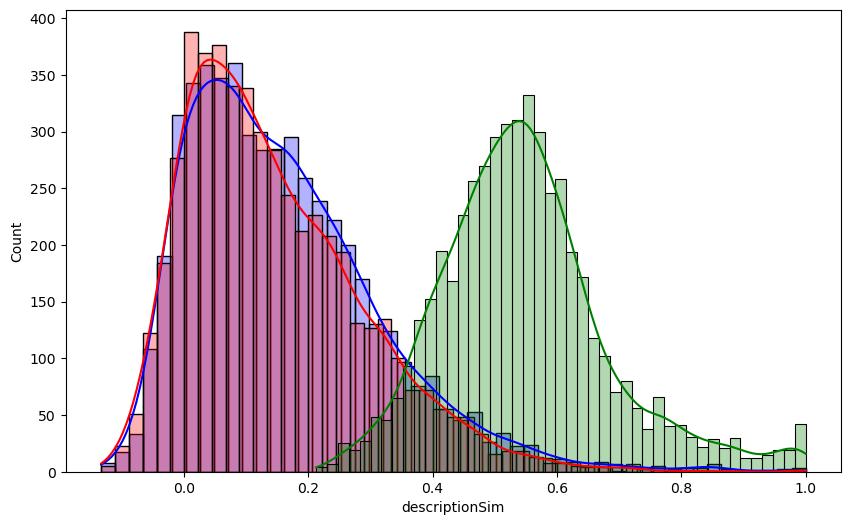

In [39]:
plt.figure(figsize=(10, 6))

sns.histplot(data=prop_neighbors_df, x='descriptionSim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=no_prop_neighbors_df, x='descriptionSim', kde=True, color='red', alpha=0.3, label='FastRP without properties')
sns.histplot(data=description_neighbors_df, x='descriptionSim', kde=True, color='green', alpha=0.3, label='Description embeddings')

plt.show()

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


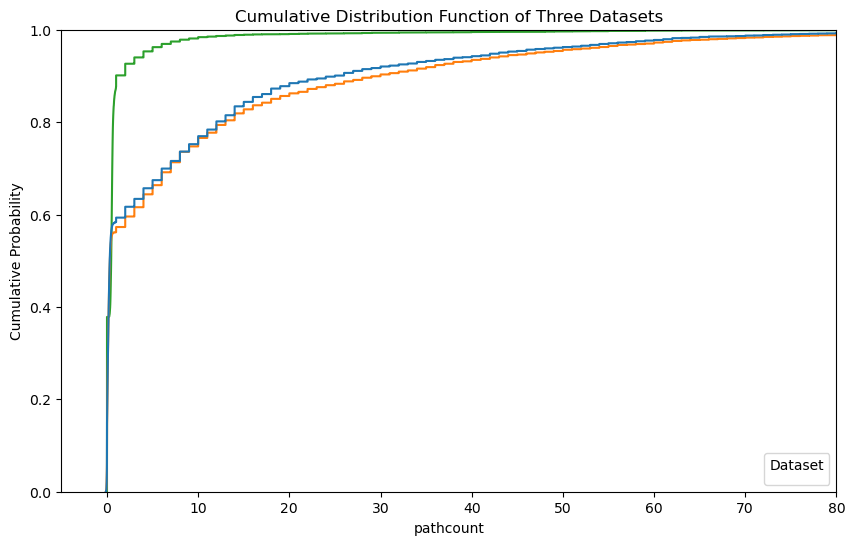

In [40]:
combined_df = pd.concat([prop_neighbors_df, no_prop_neighbors_df, description_neighbors_df], axis=1, keys=['Property fastRP', 'No property fastRP', 'Description embedding'])

# Step 2: Melt the dataframe to long format
melted_df = combined_df.melt(var_name='Dataset', value_name='pathCount')

# Step 3: Create the CDF plot
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=melted_df, x='pathCount', hue='Dataset')

# Step 4: Customize the plot
plt.title('Cumulative Distribution Function of Three Datasets')
plt.xlabel('pathcount')
plt.ylabel('Cumulative Probability')
plt.xlim(right=80)
plt.xlim(left=-5)

# Step 5: Add a legend
plt.legend(title='Dataset')

# Step 6: Show the plot
plt.show()